<a href="https://colab.research.google.com/github/Bryan-Az/FeatureEngineering/blob/main/Kepler_Stars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from pydub import AudioSegment
import librosa, librosa.display
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import numpy as np
from pydub import AudioSegment
import librosa, librosa.display
import matplotlib.pyplot as plt

# Data Transformation / Export

In [ ]:
kepler_files_mp3 = ['DataWavs/Kepler Star KIC7671081B.mp3', 'DataWavs/Kepler Star KIC12268220C.mp3']

In [ ]:
kepler_files_wav = []
for fn in kepler_files_mp3:
    wav_name = fn[:-4] + '.wav'
    # Convert MP3 to WAV
    audio = AudioSegment.from_mp3(fn)
    audio.export(wav_name, format="wav")
    kepler_files_wav.append(wav_name)

In [ ]:
kepler_files_wav

['DataWavs/Kepler Star KIC7671081B.wav',
 'DataWavs/Kepler Star KIC12268220C.wav']

# Data Loading

In [ ]:
kepler_df=pd.DataFrame(columns=['star_id','raw_data','frame_rate','duration'])

In [ ]:
for i in range(len(kepler_files_wav)):
    kepler_df.loc[i,'star_id'] = kepler_files_wav[i].split('/')[1].split(' ')[2].split('.')[0]
    kepler_df.loc[i,'raw_data'], kepler_df.loc[i,'frame_rate'] = librosa.load(kepler_files_wav[i])
    kepler_df.loc[i,'duration'] = librosa.get_duration(y=kepler_df.loc[i,'raw_data'], sr=kepler_df.loc[i,'frame_rate'])

In [ ]:
kepler_df

,star_id,raw_data,frame_rate,duration
0,KIC7671081B,"[-1.3327334e-10, 4.311784e-10, -5.068666e-10, ...",22050,20.592018
1,KIC12268220C,"[8.320895e-09, -5.642992e-09, -7.026414e-09, -...",22050,7.032018


# Feature Engineering
## Beat Tracking

In [ ]:
def create_beat_features(star_id):
    hop_length = 512
    star_index = kepler_df[kepler_df['star_id']==star_id].index[0]
    y = kepler_df.loc[star_index,'raw_data']
    sr = kepler_df.loc[star_index,'frame_rate']
    tempo, beats = librosa.beat.beat_track(y=y, sr=sr, hop_length=hop_length)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.median)
    t_frames=librosa.frames_to_time(beats, sr=sr)
    return {'onset_env':onset_env, 'tempo':tempo, 'beats':beats, 't_frames':t_frames, 'y':y, 'sr':sr}

In [ ]:
kic_b = create_beat_features('KIC7671081B')
kic_c = create_beat_features('KIC12268220C')

## Spectrogram Overviews
STFT (Short-Frame Fourier Transform) provides a more technical, precise, linear representation of frequency, whereas the Mel Spectrogram provides a representation that is thought to be more relevant to human perception of sound, focusing on the (lower) frequencies that humans are more sensitive to and capable of differentiating. We can see that in both the mel-spectogram (with beat tracking comparison), as well as in the STFT Spectogram, that the frequencies above ~3000hz have decibled >70dB, and are therefore not as relevant to the human ear.

This issue is addressed in the Constant-Q Transform, which is a more logarithmic representation of frequency, and is more similar to the Mel Spectrogram, but with a more precise frequency representation. For example, the frequencies above ~3000hz are removed in the spectogram of the CQT, and the frequencies below ~100hz are more clearly defined. Further, I included the ability to scale the resolution of the frequencies in the CQT, which is useful for comparing the same audio file with different frequency resolutions. Finally, the y-axis is transformed into the musical note representation, which is more intuitive for the human ear and for understanding the types of sound present within the spectrogram for interpretability.

## Mel-Scaled Spectrogram

In [ ]:
def plot_specbeat(star_id):
    beat_features = create_beat_features(star_id)
    hop_length = 512
    fig, ax = plt.subplots(nrows=2, sharex=True)
    #increase size of the plot
    fig.set_size_inches(18.5, 10.5)
    times = librosa.times_like(beat_features['onset_env'], sr=beat_features['sr'], hop_length=hop_length)
    M = librosa.feature.melspectrogram(y=beat_features['y'], sr=beat_features['sr'], hop_length=hop_length)
    librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                             y_axis='mel', x_axis='time', hop_length=hop_length,
                             ax=ax[0])
    ax[0].label_outer()
    ax[0].set(title='Mel spectrogram of Kepler Light Curve Waves of Star ' + star_id + ', with Beats')
    ax[1].plot(times, librosa.util.normalize(beat_features['onset_env']),
               label='Onset strength')
    ax[1].vlines(times[beat_features['beats']], 0, 1, alpha=0.5, color='r',
                 linestyle='--', label='Beats')
    ax[1].legend()

### Kepler Light Curve to Sound Wave Mel-Spectogram w/ Beat Tracking (KIC7671081B)

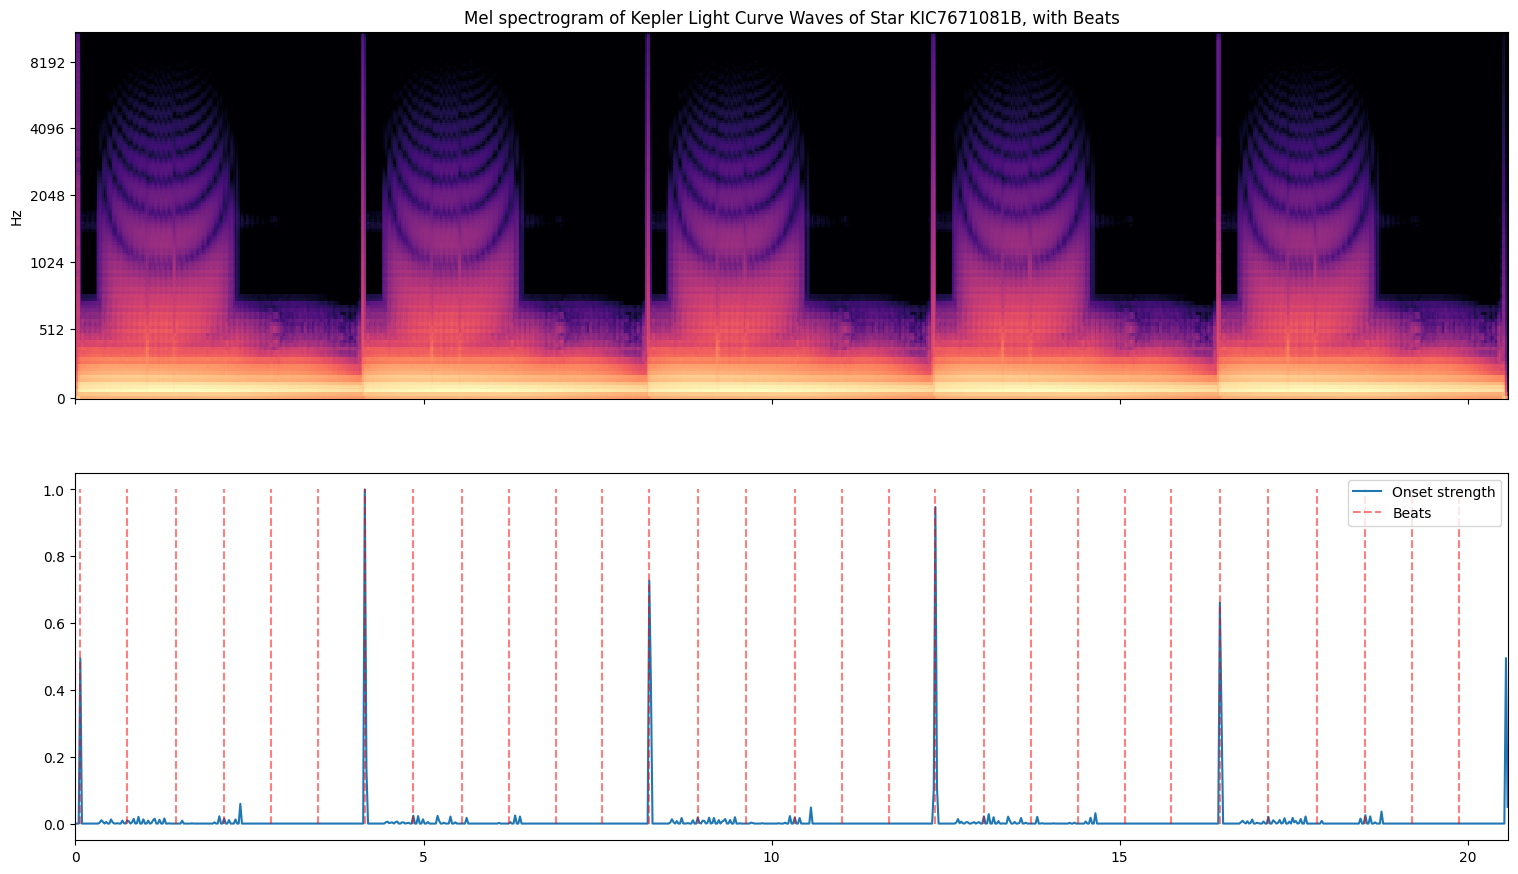

In [ ]:
plot_specbeat('KIC7671081B')

### Kepler Light Curve to Sound Wave Mel-Spectogram w/ Beat Tracking (KIC12268220C)

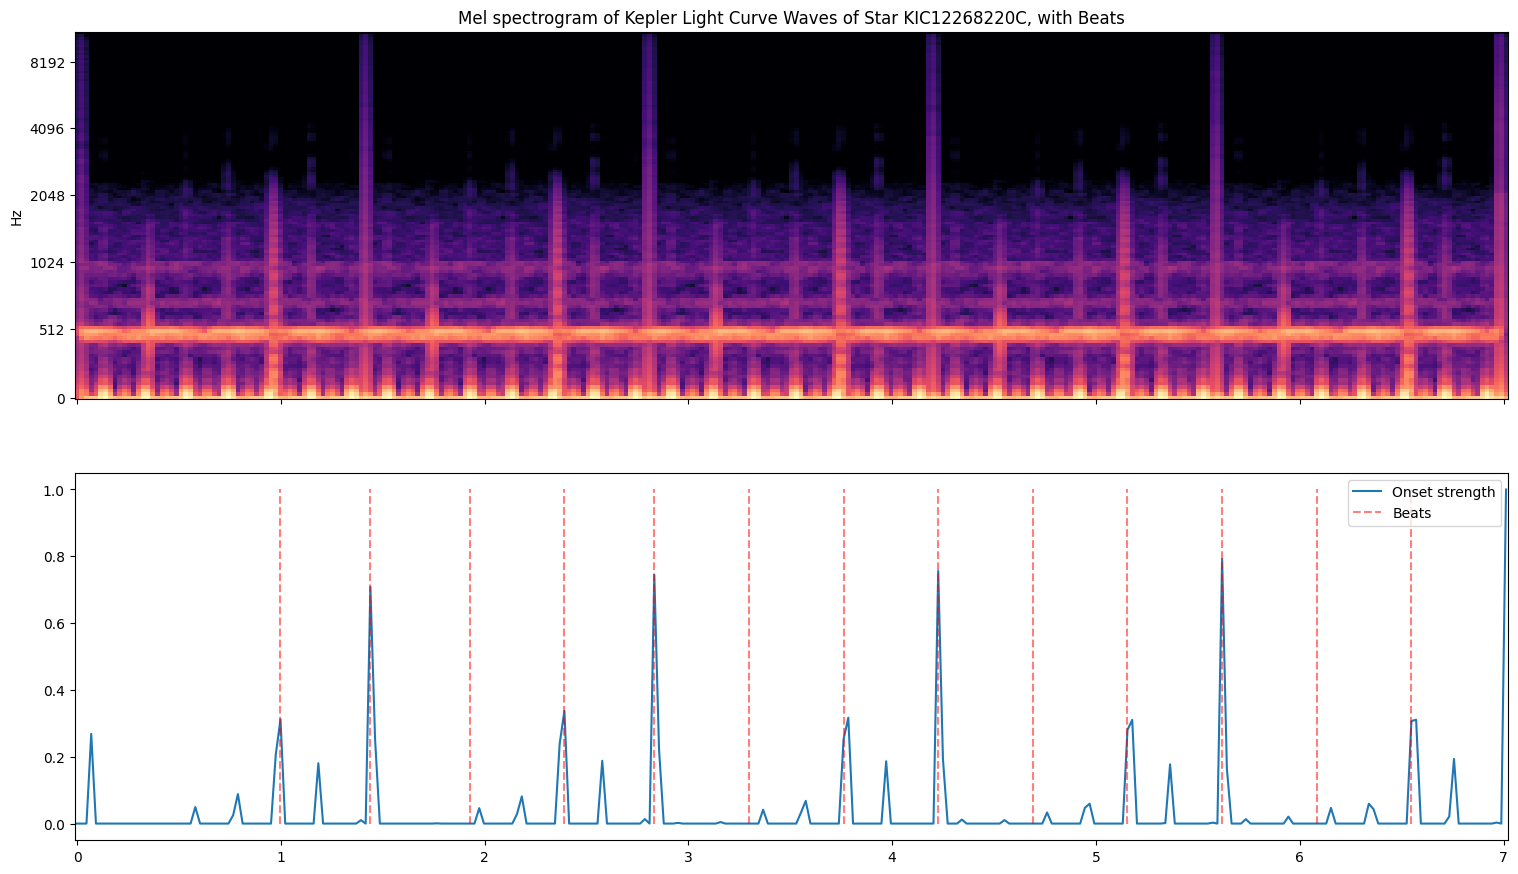

In [ ]:
plot_specbeat('KIC12268220C')

## Short-Time Fourier Transform (STFT)

In [ ]:
def plot_stft_light_curve(star_id):
    audio_features = create_beat_features(star_id)
    centered_frames = np.abs(librosa.stft(audio_features['y']))
    #plot a single fig, ax
    fig, ax = plt.subplots()
    #increase size of the plot
    fig.set_size_inches(15, 8.5)
    # display a spectrogram of stft
    img = librosa.display.specshow(librosa.amplitude_to_db(centered_frames, ref=np.max),
                                   y_axis='log', x_axis='time', ax=ax)
    ax.set(title='STFT of Kepler Light Curve Waves of Star ' + star_id)
    fig.colorbar(img, ax=ax, format="%+2.f dB")

### Kepler Light Curve to Sound Wave Short-Time Fourier Transform (STFT) (KIC7671081B)

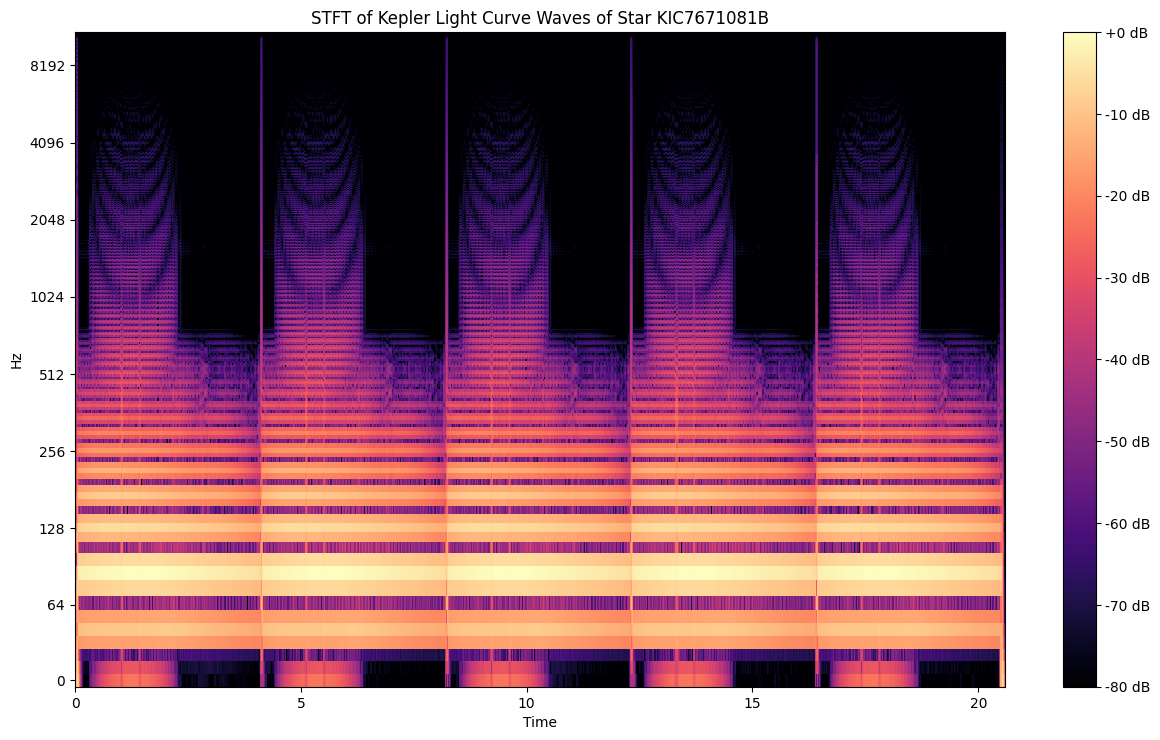

In [ ]:
plot_stft_light_curve('KIC7671081B')

### Kepler Light Curve to Sound Wave Short-Time Fourier Transform (STFT) (KIC12268220C)

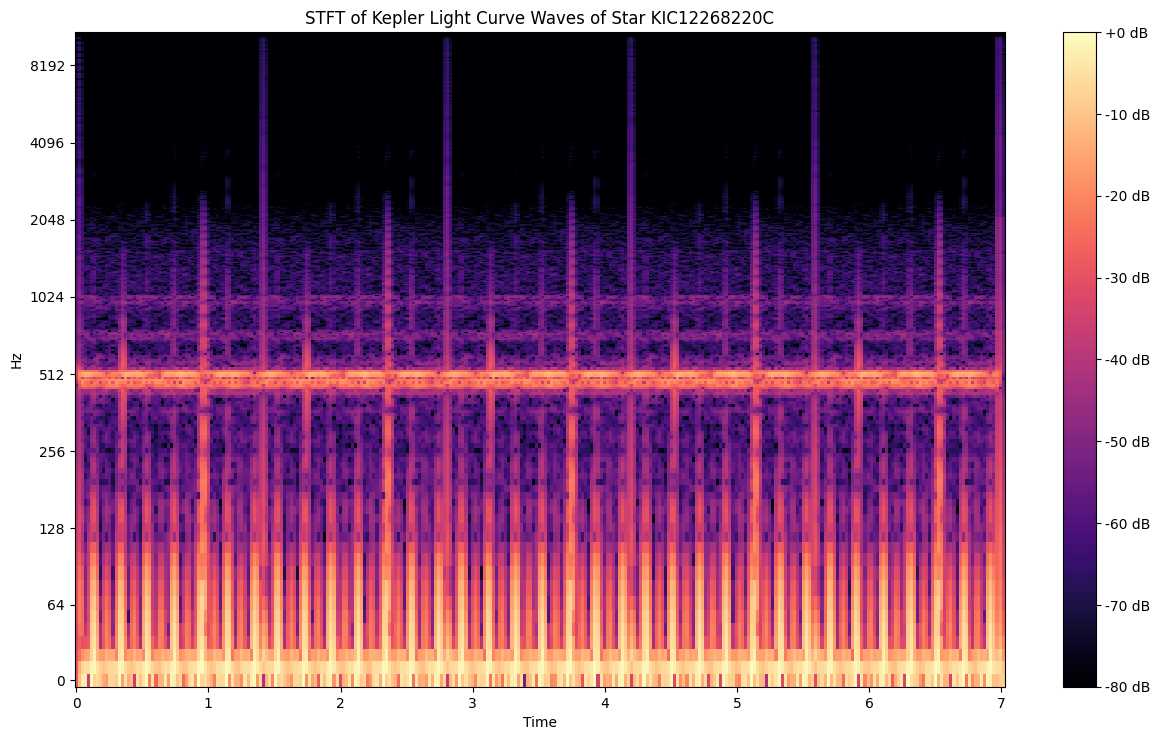

In [ ]:
plot_stft_light_curve('KIC12268220C')

## Constant-Q Transform (CQT)

In [ ]:
def plot_cqt_light_curves(star_id, frequency_res_factor=1):
    audio_features = create_beat_features(star_id)
    # scaling the frequency to fit the plot
    # Given values from create_beat_features
    sr = audio_features['sr']  # sample rate
    fmin = librosa.note_to_hz('C1')  # minimum frequency
    bins_per_octave = 12 # 12 bins per octave

    # Nyquist limit
    nyquist = sr / 2

    # Maximum number of bins
    n_bins_default = 60
    n_bins_max = np.floor(bins_per_octave * np.log2(nyquist / fmin))  # the highest bin count without exceeding Nyquist

    n_bins = int(n_bins_max)
    if (frequency_res_factor >= 1) and (frequency_res_factor < 1.7):
        if frequency_res_factor == 1:
            n_bins = int(n_bins_default)
        else:
            n_bins_var = int(n_bins_default * frequency_res_factor)
            if n_bins_var > n_bins_max:
                print('n_bins_var exceeds Nyquist limit, setting n_bins to n_bins_max')
                n_bins = int(n_bins_max)
                scale_factor = int(n_bins / n_bins_default)
                bins_per_octave *= scale_factor
            else:
                n_bins = n_bins_var
                bins_per_octave = int(bins_per_octave * frequency_res_factor)
        C = np.abs(librosa.cqt(y=audio_features['y'], sr=audio_features['sr'], fmin=librosa.note_to_hz('C1'), n_bins= n_bins, bins_per_octave=bins_per_octave))
        #plot a single fig, ax
        fig, ax = plt.subplots()
        #increase size of the plot
        fig.set_size_inches(15, 8.5)
        img = librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                                       sr=audio_features['sr'], x_axis='time', y_axis='cqt_note', ax=ax)
        # set title
        ax.set(title='Constant-Q power spectrum of Kepler Light Curve Waves of Star ' + star_id)
        fig.colorbar(img, ax=ax, format="%+2.0f dB")
    else:
        print('frequency_res_factor must b int >= 1 and < 1.7')

### Kepler Light Curve to Sound Wave Constant-Q Transform (CQT) (KIC7671081B)

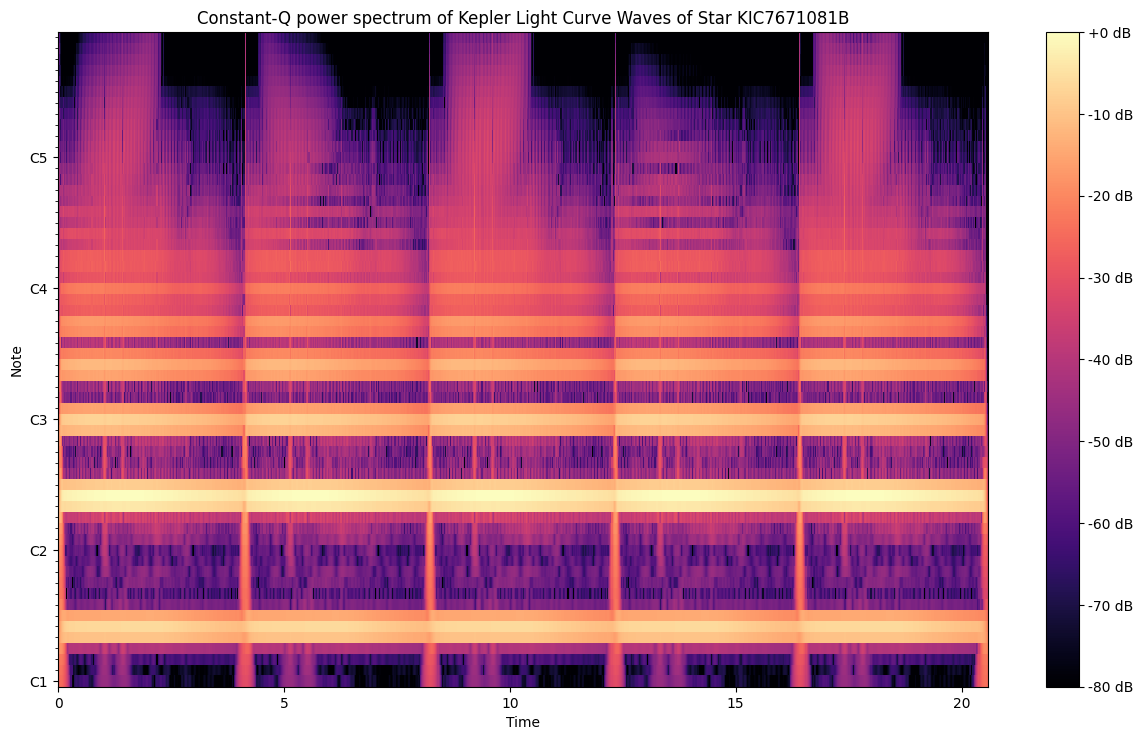

In [ ]:
# plotting the regular CQT
plot_cqt_light_curves('KIC7671081B', frequency_res_factor=1)

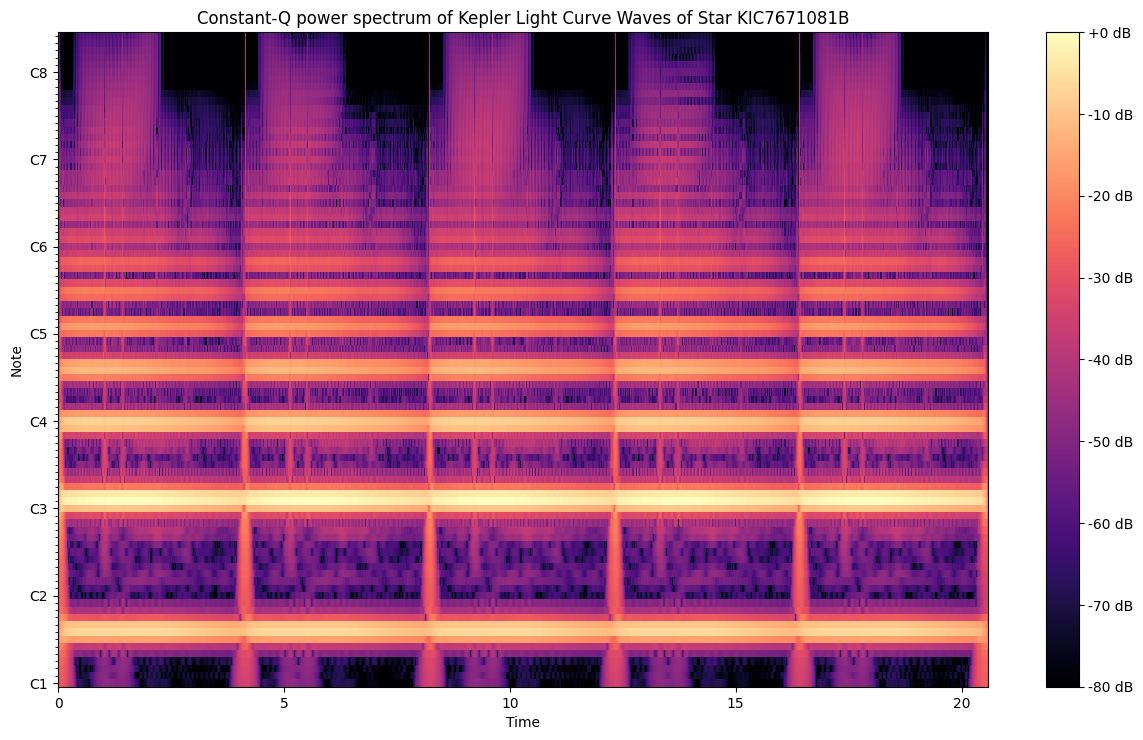

In [ ]:
# plotting with a higher frequency resolution
plot_cqt_light_curves('KIC7671081B', frequency_res_factor=1.5)

### Kepler Light Curve to Sound Wave Constant-Q Transform (CQT) (KIC12268220C)

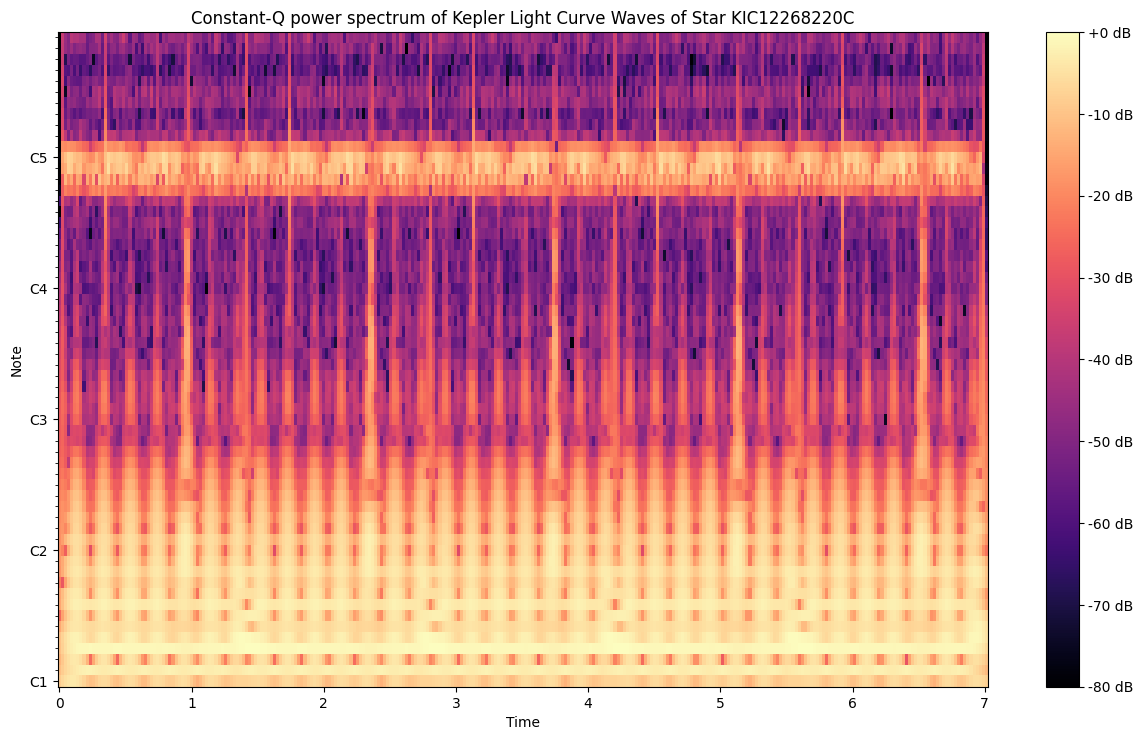

In [ ]:
# plotting the regular CQT
plot_cqt_light_curves('KIC12268220C', frequency_res_factor=1)

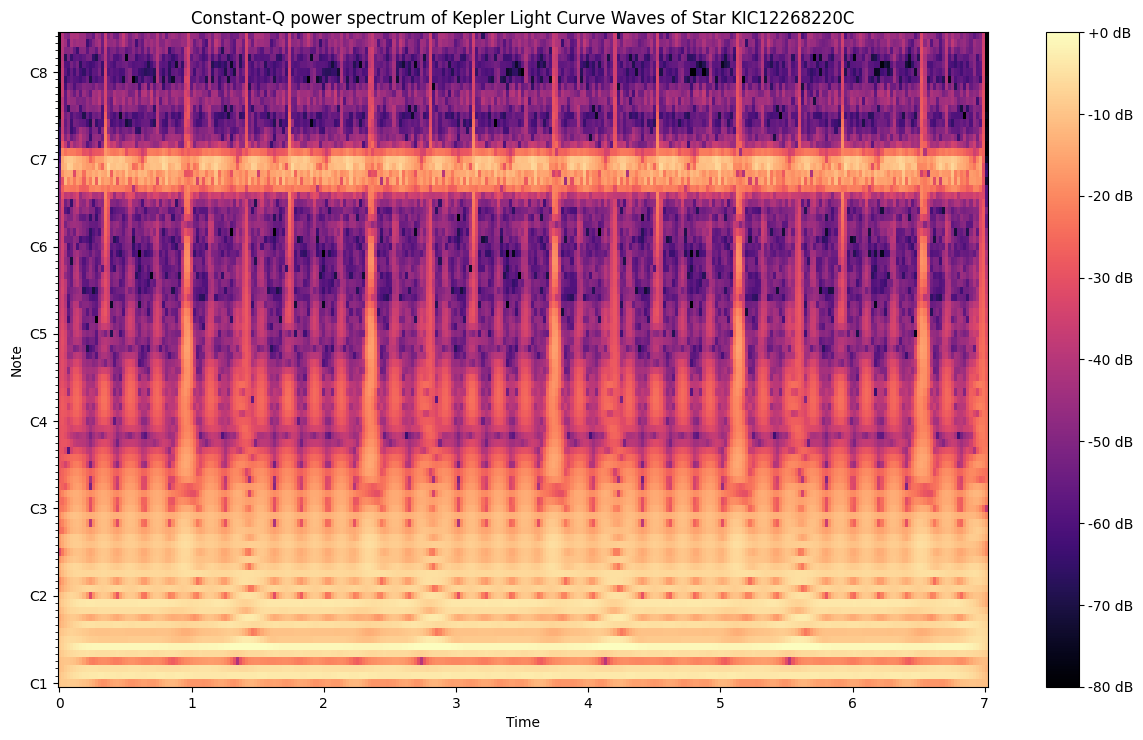

In [ ]:
# plotting with a higher frequency resolution
plot_cqt_light_curves('KIC12268220C', frequency_res_factor=1.5)